In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        self.R1.resistance = self.__R * w
        self.R2.resistance = self.__R * (1.0-w)
        

# *about*

Here some simple distortion circuits are analysed. These circuits use overdrive and diodes for clipping. Clipping adds harmonics to the signal. There is soft and hard clipping. soft clipping adds the even harmonics to the signal and hard clipping the odds [xxx]. When we drive the signal to much, the result is a simple square wave. How can more interesting results be achieved. 

# *overdrive 250*


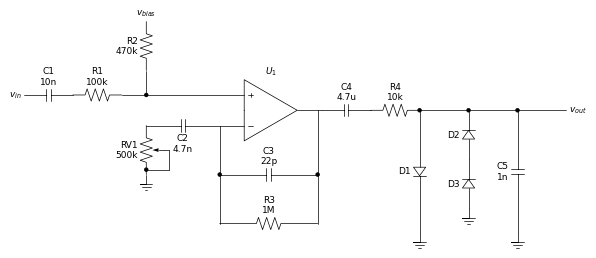

In [26]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).flip().label('$U_1$'))

#draw opamp
d += elm.Line(at=op1.in2).left().length(4)
d += elm.Dot()
d.push()
d += elm.Line().left().length(1)
d += elm.Resistor().label('R1\n100k', loc='top')
d += elm.Capacitor().label('$v_{in}$', loc='lft').label('C1\n10n', loc='top')

#bias Voltage
d.pop()
d += elm.Line().up().length(1)
d += elm.Resistor().label('R2\n470k', loc='top').label('$v_{bias}$', loc='right')

#opamp feedback loop
d += elm.Line(at=op1.in1).left().length(1)
d.push()
d += elm.Line('down')
d.push()
d += elm.Capacitor().right().length(4).label('C3\n22p', loc='top')
d += elm.Dot()

d.pop()
d += elm.Dot()
d += elm.Line('down')
d += elm.Resistor().right().length(4).label('R3\n1M', loc='top')
d += elm.Line('up').toy(op1.out)

d.pop()
d += elm.Capacitor().left().length(3).label('C2\n4.7n', loc='bottom')
d += ( pot1 := elm.Potentiometer().down().label('RV1\n500k', loc='top') )
d += elm.Ground()
d += elm.Line().at(pot1.tap).right().length(0.2)
d += elm.Line().down().length(0.8)
d += elm.Line().left().tox(pot1.end)
d += elm.Dot()

#and the output
d += elm.Line(at=op1.out).right().length(1)
d += elm.Capacitor().label('C4\n4.7u', loc='top')
d += elm.Resistor().label('R4\n10k', loc='top')
d.push()
d += elm.Line()
d.push()
d += elm.Line()
d.push()
d += elm.Line().label('$v_{out}$', loc='right')

d.pop()
d += elm.Dot()
d += elm.Capacitor().down().length(5).label('C5\n1n', loc='top')
d += elm.Ground()

d.pop()
d += elm.Dot()
d += elm.Diode().down().reverse().label('D2', loc='top')
d += elm.Diode().down().reverse().label('D3', loc='top')
d += elm.Ground()

d.pop()
d += elm.Dot()
d += elm.Diode().down().length(5).label('D1', loc='top')
d += elm.Ground()

d.draw()

The DOD is a very simple circuits that uses some overdive but mainly diode clipping. Such circuits are very common. There are variations in the tpes and wiring of the diodes. One example is the Batter Acid. 

In [4]:
circuit = Circuit('Overdrive250')
circuit.include(spice_library['TL072'])
circuit.include(spice_library['D1N4148'])

circuit.V('1', '+9V', circuit.gnd, 'DC 9')
circuit.V('2', 'bias', circuit.gnd, 'DC 4.5V')
circuit.V('3', 'Vin', circuit.gnd, 'DC 0 Sine ( 0 800m 1k)')

#the opamps
#                     NON-INVERTING INPUT
#                     |           INVERTING INPUT
#                     |           |           POSITIVE POWER SUPPLY
#                     |           |           |      NEGATIVE POWER SUPPLY
#                     |           |           |      |            OUTPUT
#                     |           |           |      |            |
circuit.X(1, 'TL072', 'op+',      'op-',      '+9V', circuit.gnd, 'opOut')

circuit.R(1, 'op+', 'R1', 100@u_kΩ)
circuit.C(1, 'R1', 'Vin', 10@u_nF)
circuit.R(2, 'op+', 'bias', 470@u_kΩ)

circuit.C(2, 'op-', 'C2', 4.7@u_nF)
circuit.R('v1', 'C2', circuit.gnd, 47@u_kΩ)

circuit.R(3, 'op-', 'opOut', 1@u_MΩ)
circuit.C(3, 'op-', 'opOut', 22@u_pF)

circuit.C(4, 'opOut', 'C4', 4.7@u_uF)
circuit.R(4, 'C4', 'R4', 10@u_kΩ)

circuit.D('1', 'R4', circuit.gnd, model='D1N4148')
circuit.D('2', 'D2', 'R4', model='D1N4148')
circuit.D('3', circuit.gnd, 'D2', model='D1N4148')

circuit.C(5, 'R4', circuit.gnd, 1@u_nF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=20@u_us, start_time=0@u_ms, end_time=2@u_ms)

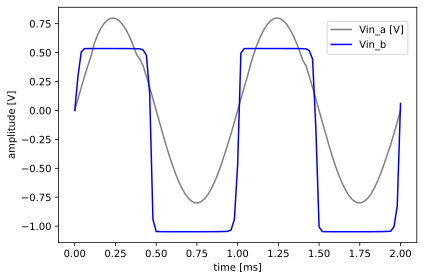

In [5]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['R4'].abscissa), analysis['R4'], color='Blue')

ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [6]:
buffer_data = []
for r in np.arange(500000, 4700, -10000) :
    circuit.Rv1.resistance = r
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    analysis_step = simulator.transient(step_time=20@u_us, start_time=0@u_ms, end_time=2@u_ms)
    buffer_data.append(analysis_step['R4'].tolist())
    
print(len(buffer_data))

50


In [7]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="Overdrive250Chart" class="400px"></canvas>
<input type="range" class="slider-width" id="Overdrive250Resistance" name="Overdrive250Resistance" min="0" max="49" value="0" step="1"></input>
<p class="content">Figure 3: Overdrive 250 Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var Overdrive250Datas = %s;

const Overdrive250Data = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: Overdrive250Datas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var Overdrive250Ctx = document.getElementById('Overdrive250Chart').getContext('2d');
var Overdrive250Chart = new Chart(Overdrive250Ctx, {
    type: 'line',
    data: Overdrive250Data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -1.2,
                max: 1,
                ticks: {
                    stepSize: 0.2
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let Overdrive250Resistance = document.getElementById('Overdrive250Resistance');
Overdrive250Resistance.addEventListener('input', function (e) {
    Overdrive250Chart.data.datasets[1].data = Overdrive250Datas[Overdrive250Resistance.value];
    Overdrive250Chart.update();

});

''' % (json.dumps(buffer_data), analysis['Vin'].abscissa.tolist(), analysis['Vin'].tolist() ) ))

<IPython.core.display.Javascript object>

The signal is nicely soft clipped. But it also has an offset. This offset comes from the uneven diode arrangement. 

## *Shin Ei FY-2*

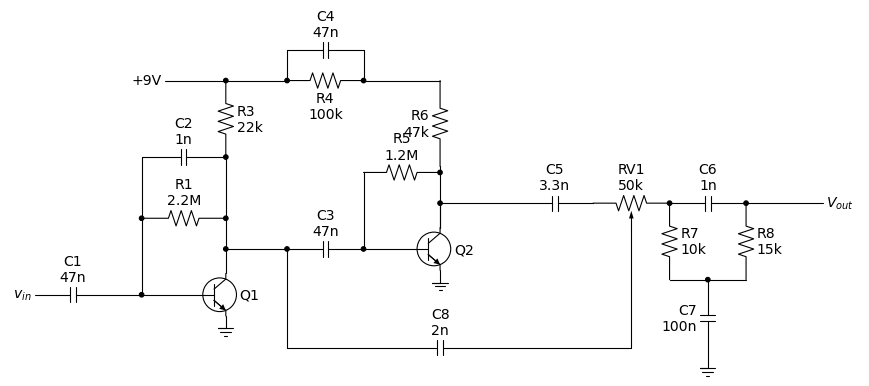

In [8]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += (q1 := elm.BjtNpn(circle=True).at([5,0]).label('Q1'))

#draw opamp
d += elm.Line(at=q1.base).left().length(2)
d += elm.Dot()
d.push()
d += elm.Line().left().length(1)
d += elm.Capacitor().label('$v_{in}$', loc='lft').label('C1\n47n', loc='top')

d.pop()
d += elm.Line().up()
d += elm.Dot()
d.push()

d += elm.Resistor().right().tox(q1.collector).label('R1\n2.2M', loc='top')
d += elm.Dot()
d.pop()
d += elm.Line().up().length(2)
d += ( c2 := elm.Capacitor().right().tox(q1.collector).label('C2\n1n', loc='top') )
d += elm.Dot()

d += elm.Line().up().at(q1.collector).length(0.8)
d += elm.Dot()
d.push()
d += elm.Line().up().toy(c2.end)
d += ( r3 := elm.Resistor().label('R3\n22k', loc='bottom') )
d += elm.Dot()

d.pop()
d += elm.Line().length(2).right()
d += ( dot := elm.Dot() )
#d.push()
d += elm.Capacitor().label('C3\n47n', loc='top')
#d += elm.Line().length(1)
d += elm.Dot()
d.push()
d += elm.Line().length(1.75)
d += (q2 := elm.BjtNpn(circle=True).label('Q2'))

d.pop()
d += elm.Line().up()
d += elm.Resistor().right().label('R5\n1.2M', loc='top')
d += elm.Dot()
 
d += elm.Line().up().at(q2.collector).length(0.8)
d += elm.Dot()
d.push()

d += elm.Line().up().at(q2.collector).length(2)
d += elm.Resistor().label('R6\n47k', loc='top').toy(r3.end)
d += elm.Line().left()
d += elm.Dot()
d.push()
d += elm.Resistor().label('R4\n100k', loc='bottom')
d += elm.Dot()
d += elm.Line().length(4).label('+9V', loc='lft')

d.pop()
d += elm.Line().up().length(1)
d += elm.Capacitor().left().label('C4\n47n', loc='top')
d += elm.Line().down().length(1)

d.pop()
d += elm.Line().right()
d += elm.Capacitor().label('C5\n3.3n', loc='top')
d += ( rv1 := elm.Potentiometer().flip().label('RV1\n50k', loc='top') )
d += elm.Dot()
d.push()
d += elm.Capacitor().label('C6\n1n', loc='top')
d += elm.Dot()
d.push()
d += elm.Line().label('$V_{out}$', loc='rgt')

d.pop()
d += elm.Resistor().down().label('R8\n15k', loc='bottom')
d += elm.Line().left().length(1.25)
d += elm.Dot()
d.push()
d += elm.Line().left().length(1.25)

d.pop()
d += elm.Capacitor().down().label('C7\n100n', loc='top')
d += elm.Ground()

d.pop()
d += elm.Resistor().down().label('R7\n10k', loc='bottom')

d += elm.Ground().at(q1.emitter)
d += elm.Ground().at(q2.emitter)

d += elm.Line().at(rv1.tap).down().length(4)
d += elm.Line().left().length(5)
d += elm.Capacitor().label('C8\n2n', loc='top')
d += elm.Line().left().tox(dot.end)
d += elm.Line().up().toy(dot.end)

d.draw()

In [9]:
circuit = Circuit('ShinEy')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+9V', circuit.gnd, 'DC 9')
circuit.V('2', 'Vin', circuit.gnd, 'DC 0 Sine ( 0 800m 1k)')

# BJT =  nc nb ne
circuit.BJT('1', 'q1c', 'q1b', circuit.gnd, model="BC547B")
circuit.BJT('2', 'q2c', 'q2b', circuit.gnd, model="BC547B")

circuit.C(1, 'q1b', 'Vin', 47@u_nF)
circuit.R(1, 'q1b', 'q1c', 2.2@u_MΩ)
circuit.C(2, 'q1b', 'q1c', 1@u_nF)
circuit.R(3, 'q1c', '+9V', 22@u_kΩ)

circuit.C(3, 'q1c', 'q2b', 47@u_nF)
circuit.R(5, 'q2b', 'q2c', 1.2@u_MΩ)

circuit.R(6, 'q2c', 'r6', 47@u_kΩ)
circuit.R(4, 'r6', '+9V', 100@u_kΩ)
circuit.C(4, 'r6', '+9V', 47@u_nF)

circuit.C(5, 'q2c', 'c5', 3.3@u_nF)

rv1 = VoltageDivider(R=50@u_kΩ, w=0.1, name='RV1')
circuit.subcircuit(rv1)
circuit.X('1', 'rv1', 'c5', 'rv1w', 'rv1')

circuit.R(100, 'rv1', 'R100', 100@u_Ω)

circuit.C(6, 'R100', 'OUT', 33@u_nF)
circuit.R(7, 'R100', 'r7', 10@u_kΩ)
circuit.R(8, 'OUT', 'r7', 15@u_kΩ)
circuit.C(7, 'r7', circuit.gnd, 100@u_nF)

circuit.C(8, 'rv1w', 'q1c', 100@u_nF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)

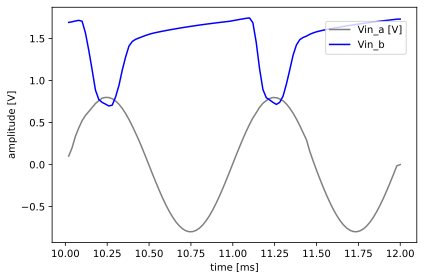

In [10]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['rv1'].abscissa), analysis['rv1'], color='Blue')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [11]:
buffer_data = []
for w in np.arange(0.02, 0.98, 0.02) :
    rv1.wiper(w)
        
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    analysis_step = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)
    buffer_data.append(analysis_step['OUT'].tolist())
    
print(len(buffer_data))

48


In [12]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="ShinEyChart" class="400px"></canvas>
<input type="range" class="slider-width" id="ShinEyResistance" name="ShinEyResistance" min="0" max="47" value="0" step="1"></input>
<p class="content">Figure 3: Shin-Ey Companion Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var ShinEyDatas = %s;

const ShinEyData = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: ShinEyDatas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var ShinEyCtx = document.getElementById('ShinEyChart').getContext('2d');
var ShinEyChart = new Chart(ShinEyCtx, {
    type: 'line',
    data: ShinEyData,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -2.2,
                max: 2.4,
                ticks: {
                    stepSize: 0.2
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let ShinEyResistance = document.getElementById('ShinEyResistance');
ShinEyResistance.addEventListener('input', function (e) {
    ShinEyChart.data.datasets[1].data = ShinEyDatas[ShinEyResistance.value];
    ShinEyChart.update();
});

''' % (json.dumps(buffer_data), analysis['Vin'].abscissa.tolist(), analysis['Vin'].tolist() ) ))

<IPython.core.display.Javascript object>

## *UBE Screamer*



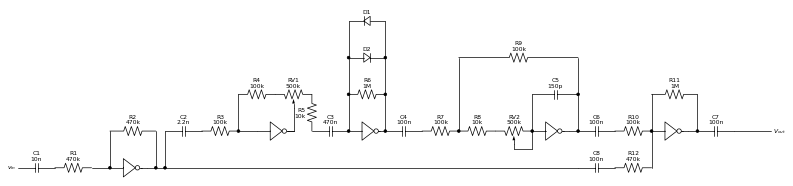

In [31]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.3, lw=0.7, fontsize=6)

d += elm.Capacitor().label('$v_{in}$', loc='lft').label('C1\n10n', loc='top')
d += elm.Resistor().label('R1\n470k', loc='top')
d += elm.Line().length(1)
d += ( d1 := elm.Dot() )
#d += elm.Line().length(1)
d += (u1 := logic.Not())
d += elm.Line().length(0.5)
d += ( d2 := elm.Dot() )
d += elm.Line().length(0.5)
d += ( d3 := elm.Dot() )
d += elm.Line().up()
d += elm.Capacitor().right().label('C2\n2.2n', loc='top')
d += elm.Resistor().label('R3\n100k', loc='top')
d += elm.Dot()
d.push()
d += elm.Line().length(1)
d += (u2 := logic.Not())

d.pop()
d += elm.Line().up()
d += elm.Resistor().right().label('R4\n100k', loc='top')
d += ( rv1 := elm.Potentiometer().flip().label('RV1\n500k', loc='top') )
#d += elm.Line().down()
d += elm.Resistor().down().label('R5\n10k', loc='top')
d += elm.Capacitor().right().label('C3\n470n', loc='top')
d += (u3 := logic.Not())
d += elm.Capacitor().right().label('C4\n100n', loc='top')
d += ( r7 := elm.Resistor().label('R7\n100k', loc='top') )

d += elm.Resistor().label('R8\n10k', loc='top')
d += ( rv2 := elm.Potentiometer().flip().label('RV2\n500k', loc='top') )
d += (u4 := logic.Not())
d += elm.Line().length(0.5)
d += ( u4d := elm.Dot() )
d += elm.Capacitor().right().label('C6\n100n', loc='top')
d += elm.Resistor().label('R10\n100k', loc='top')
d += (u5 := logic.Not())
d += elm.Line().length(0.5)
d += ( u5d := elm.Dot() )
d += elm.Capacitor().label('C7\n100n', loc='top')
d += elm.Line().label('$V_{out}$', loc='rgt')


d += elm.Line().up().at(d1.end)
d += elm.Resistor().right().tox(d2.end).label('R2\n470k', loc='top')
d += elm.Line().down()

d += elm.Line().at(rv1.tap).down().toy(u2.out)
d += elm.Line().left().tox(u2.out)

d += elm.Dot().at(u3.start)
d += elm.Line().up()
d += elm.Dot()
d.push()

d += elm.Resistor().right().label('R6\n1M', loc='top')
d += elm.Line().down()
d += elm.Dot()

d.pop()
d += elm.Line().up()
d += elm.Dot()
d.push()
d += elm.Diode().right().label('D2', loc='top')
d += elm.Line().down()
d += elm.Dot()

d.pop()
d += elm.Line().up()
d += elm.Diode().right().reverse().label('D1', loc='top')
d += elm.Line().down()
d += elm.Dot()

d += elm.Dot().at(r7.end)
d += elm.Line().up().length(4)
d += elm.Resistor().right().tox(u4d.end).label('R9\n100k', loc='top')
d += elm.Line().down().length(4)

d += elm.Dot().at(rv2.end)
d += elm.Line().up()
d += elm.Capacitor().right().tox(u4d.end).label('C5\n150p', loc='top')
d += elm.Dot()

d += elm.Line().down().length(1).at(rv2.end)
d += elm.Line().left().tox(rv2.tap)
d += elm.Line().up().toy(rv2.tap)

d += elm.Dot().at(u5.start)
d += elm.Line().up()
d += elm.Resistor().right().tox(u5d.end).label('R11\n1M', loc='top')
d += elm.Line().down()
 
d += elm.Line().down().toy(d3.start).at(u5.start)
d += elm.Resistor().left().label('R12\n470k', loc='top')
d += elm.Capacitor().label('C8\n100n', loc='top')
d += elm.Line().tox(d3.start)

d.draw()


In [14]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['D1N4148'])

rv1 = VoltageDivider(R=500@u_kΩ, w=0.5, name='RV1')
circuit.subcircuit(rv1)
rv2 = VoltageDivider(R=500@u_kΩ, w=0.5, name='RV2')
circuit.subcircuit(rv2)

circuit.V('1', '+9V', circuit.gnd, 'DC 9')
circuit.V('2', 'Vin', circuit.gnd, 'DC 0 Sine ( 0 800m 1k)')

circuit.X('1', '4069UB', 'X1in', 'X1out', '+9V', circuit.gnd)
circuit.X('2', '4069UB', 'X2in', 'X2out', '+9V', circuit.gnd)
circuit.X('3', '4069UB', 'X3in', 'x3out', '+9V', circuit.gnd)
circuit.X('4', '4069UB', 'X4in', 'X4out', '+9V', circuit.gnd)
circuit.X('5', '4069UB', 'X5in', 'X5out', '+9V', circuit.gnd)

circuit.C(1, 'Vin', 'C1', 10@u_nF)
circuit.R(1, 'C1', 'X1in', 470@u_kΩ)
circuit.R(2, 'X1in', 'X1out', 470@u_kΩ)

circuit.C(2, 'X1out', 'C2', 10@u_nF)
circuit.R(3, 'C2', 'X2in', 100@u_kΩ)
circuit.R(4, 'X2in', 'R4', 100@u_kΩ)
circuit.X(6, 'rv1', 'rv1', 'R4', 'X2out')

circuit.R(5, 'rv1', 'R5', 10@u_kΩ)
circuit.C(3, 'R5', 'X3in', 470@u_nF)

circuit.R(6, 'X3in', 'X3out', 1@u_MΩ)
circuit.D('1', 'X3in', 'X3out', model='D1N4148')
circuit.D('2', 'X3out', 'X3in', model='D1N4148')

circuit.C(4, 'X3out', 'C4', 100@u_nF)
circuit.R(7, 'C4', 'R7', 100@u_kΩ)
circuit.R(8, 'R7', 'R8', 10@u_kΩ)
circuit.X(7, 'rv2', 'R8', 'X4in', 'X4in')
circuit.C(5, 'X4out', 'X4in', 150@u_pF)
circuit.R(9, 'R7', 'X4out', 100@u_kΩ)

circuit.C(6, 'X4out', 'C6', 100@u_nF)
circuit.R(10, 'C6', 'X5in', 100@u_kΩ)
circuit.R(11, 'X5out', 'X5in', 1@u_MΩ)

circuit.C(7, 'X5out', 'Vout', 100@u_nF)
circuit.R('load', 'Vout', circuit.gnd, 100@u_kΩ)

circuit.C(8, 'X1out', 'C8', 100@u_nF)
circuit.R(12, 'C8', 'X5in', 470@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=40@u_us, start_time=10@u_ms, end_time=12@u_ms)

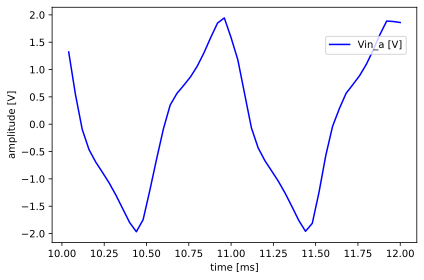

In [15]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['Vout'].abscissa), analysis['Vout'], color='Blue')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [16]:
buffer_data = []
for w in np.arange(0.02, 0.98, 0.02) :
    rv1.wiper(w)
        
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    analysis_step = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)
    buffer_data.append(analysis_step['Vout'].tolist())
    
print(len(buffer_data))

48


In [17]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="UBEChart" class="400px"></canvas>
<input type="range" class="slider-width" id="UBEResistance" name="UBEResistance" min="0" max="47" value="0" step="1"></input>
<p class="content">Figure 3: UBE screamer Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var UBEDatas = %s;

const UBEData = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: UBEDatas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var UBECtx = document.getElementById('UBEChart').getContext('2d');
var UBEChart = new Chart(UBECtx, {
    type: 'line',
    data: UBEData,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -2.2,
                max: 2.4,
                ticks: {
                    stepSize: 0.2
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let UBEResistance = document.getElementById('UBEResistance');
UBEResistance.addEventListener('input', function (e) {
    UBEChart.data.datasets[1].data = UBEDatas[UBEResistance.value];
    UBEChart.update();
});

''' % (json.dumps(buffer_data), analysis['Vin'].abscissa.tolist(), analysis['Vin'].tolist() ) ))

<IPython.core.display.Javascript object>

# *references*

- [DOD-250-Overdrive](http://beavisaudio.com/schematics/DOD-250-Overdrive-Schematic.htm) Schematic at beavisaudio
- [Shin-Ey companion](https://www.diystompboxes.com/smfforum/index.php?topic=118397.0) at diystompboxes
- [UBE Screamer](http://www.runoffgroove.com/ubescreamer.html) at runoffgroove
- [multiband distortion processor](https://static1.squarespace.com/static/5e6e99e8bd2f8a6de8454feb/t/5e77db16e8ff44374c24b124/1584913176675/MBD+BOM+and+build.pdf) Variation of the Shin-Ey distortion from NLC